# 1. Add the human_assistance tool
This tool uses interrupt to receive information from a human.

In [ ]:
pip install -U "langchain[openai]" --break-system-packages

In [1]:
# from langchain_tavily import TavilySearch

# tool = TavilySearch(max_results=2)
# tools = [tool]

from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1-mini")

We can now incorporate it into our StateGraph with an additional tool:

In [2]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool, InjectedToolCallId
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolMessage

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

graph_builder = StateGraph(State)

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 2. Compile the graph
We compile the graph with a checkpointer, as before:

In [3]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

# 3. Visualize the graph (optional)
Visualizing the graph, you get the same layout as before – just with the added tool!

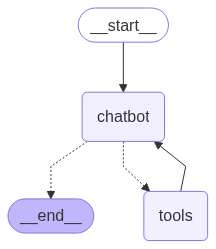

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# 4. Prompt the chatbot
Now, prompt the chatbot with a question that will engage the new human_assistance tool:

In [5]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_PkthPOteXtegdavYKQzo3EZn)
 Call ID: call_PkthPOteXtegdavYKQzo3EZn
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph release date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph 0.4.8 Image 5: LangGraph Logo Install LangGraph: from langgraph.prebuilt import create_react_agent Or, to learn how to build an agent workflow with a customizable architecture, long-term memory, and other complex task handling, see the LangGraph basics tutorials. LangGraph p

### inspect the graph state, you see that it stopped at the tools node:

In [6]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

# 4. Add human assistance¶
The chatbot failed to identify the correct date, so supply it with information:

In [7]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_Y2tK7yUQgER9O6vVex2r23ps)
 Call ID: call_Y2tK7yUQgER9O6vVex2r23ps
  Args:
    name: LangGraph
    birthday: 2023-01-01
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024. If you need any more information or help, please let me know!


### these fields are now reflected in the state:

In [10]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

# 5. Manually update the state
LangGraph gives a high degree of control over the application state. For instance, at any point (including when interrupted), you can manually override a key using graph.update_state:

In [9]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0557d5-d252-6bc4-8006-fe40373d3ae5'}}

# COMBINED

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)